In [24]:
# ! pip install --upgrade tensorflow

In [ ]:
import tensorflow_probability.substrates.jax as tfp

In [4]:
import jax.numpy as jnp
import jax
from jax import random

from flax import linen as nn
from flax.training import train_state

import optax
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## The Dataset

(-2.0, 2.0)

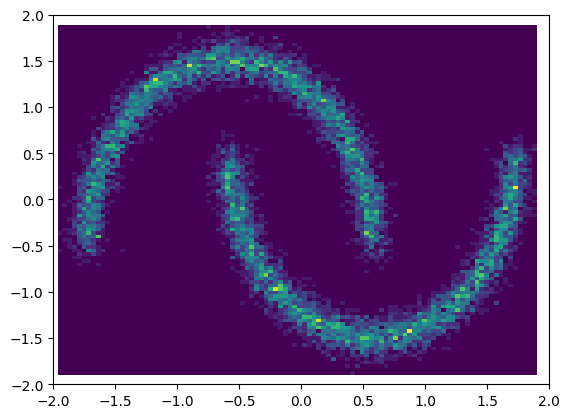

In [5]:
from sklearn import datasets, preprocessing

n_samples = 10_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

In [8]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [18]:
class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 20
    num_out: int = 2

    def setup(self):
        self.encoder = MLP(out_dim=self.num_latents * 2)
        self.decoder = MLP(out_dim=self.num_out)

    def __call__(self, x, z_rng):

        # Get variational parameters from encoder
        enc = self.encoder(x).reshape(x.shape[0], self.num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]

        # Sample from variational distrib. of latents
        z = tfp.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar))).sample(seed=z_rng)

        # Decode
        recon_x = self.decoder(z)

        return recon_x, mu, logvar

    def generate(self, z):
        return self.decoder(z)

@jax.vmap
def kl_divergence(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior
    """
    prior_latent = tfp.distributions.Normal(loc=0, scale=1)  # Prior
    q_latent = tfp.distributions.Normal(loc=mu, scale=jnp.sqrt(jnp.exp(logvar)))  # Variational latent distrib.
    
    return tfp.distributions.kl_divergence(q_latent, prior_latent).sum()

@jax.vmap
def mse_loss(pred, true):
    """ Gaussian MSE
    """
    return jnp.mean((pred - true) ** 2)

def compute_metrics(recon_x, x, mu, logvar):
    mse_loss_val = mse_loss(recon_x, x).mean()
    kld_loss = kl_divergence(mu, logvar).mean()
    return {
      'recon_loss': mse_loss_val,
      'kl_div': kld_loss,
      'loss': mse_loss_val + kld_loss
    }

def model_vae():
    return VAE(num_latents=32)

In [19]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = model_vae().apply({'params': params}, batch, z_rng)

        reco_loss = mse_loss(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = reco_loss + kld_loss
        return loss
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

In [27]:
batch_size = 16
num_latents= 32
rng = jax.random.PRNGKey(42)
learning_rate = 3e-4
train_steps = 10000

rng, key = random.split(rng)

init_data = jnp.ones((batch_size, 2), jnp.float32)

state = train_state.TrainState.create(
    apply_fn=model_vae().apply,
    params=model_vae().init(key, init_data, rng)['params'],
    tx=optax.adamw(learning_rate, weight_decay=1e-5),
)

In [86]:
@jax.jit
def eval(params, z):
    def eval_model(vae):
        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, 160, 160, 1)
        return generate_images

    return nn.apply(eval_model, model_vae())({'params': params})

In [28]:
# rng, z_key, eval_rng = random.split(rng, 3)

# for t in tqdm(range(train_steps)):
#     idx = jax.random.choice(rng, train_data.shape[0], shape=(batch_size,))
#     batch = jnp.array(train_data[idx])
#     rng, key = random.split(rng)
#     state = train_step(state, batch, key)

In [191]:
rng = jax.random.PRNGKey(12)
rng, z_key, eval_rng = random.split(rng, 3)
z = jax.random.normal(z_key, (16, num_latents))